# Response analysis


##### 1. Response expression differential analysis - 
twice: (1) tumor cells and (2) immune cells separately - finds markers across all (protein coding) genes and draw heatmaps. - DONE

##### 2. Response association with clusters analysis - 
Each cluster see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.

##### 3. GEP association with response (1) -
Per program, take all usage values of cells coming from R patients vs. NR patients, and perform Wilcoxon ranksum test.

##### 4. GEP association with response (2) - 
Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between R and NR patients.


In [1]:
# ------- SERVER EXTENSIONS ---------
lib =  r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\classifying-response-to-immunotherapy\utilities\droplet_dataset'
lib2 = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\classifying-response-to-immunotherapy\utilities'
lib3 = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\classifying-response-to-immunotherapy\data_analysis'
lib4 = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\classifying-response-to-immunotherapy'
lib5 = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\classifying-response-to-immunotherapy\scripts'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
# ------- SERVER EXTENSIONS ---------import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
import pickle
# from Bio.Cluster import kcluster
import os
import numpy as np
import yaml
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import pyclustering
import matplotlib.pylab as plt
import seaborn as sb
from os.path import join
plt.rcParams['figure.dpi'] = 400
import seaborn as sns
from utilities.general_helpers import sort_dic
from utilities.general_helpers import transpose
from general_helpers import create_folder
from scipy.stats import ranksums, wilcoxon
from shutil import copyfile
import matplotlib.pyplot as plt
import random

##### Loads clinical table to get labels - R/NR

In [2]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\Data\tables\clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\Data\tables\edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:46,:][['Patient id', 'Clinical response']]
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}

# adds CRITERIA response into clinical df
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])

In [3]:
melanoma_clinical_data.head(5)

Patient id                Clinical response response
0        M97                                R        R
1        M98  R (had a response in 2016-2019)        R
2        M99                          NR (PD)       NR
3       M100                          NR (SD)       NR
4       M101                     NED- 10/5/20        R

#### Builds response/non_response sample list

In [4]:
response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'R']['Patient id'].tolist()
non_response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'NR']['Patient id'].tolist()
no_used_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'not in use for now']['Patient id'].tolist()

print(f'number reponse_samples: {len(response_samples)}')
print(f'number non_reponse_samples: {len(non_response_samples)}')
print(f'number non_reponse_samples: {len(no_used_samples)}')

number reponse_samples: 14
number non_reponse_samples: 25
number non_reponse_samples: 7


#### Loads tumor & immune cohort:

In [5]:
# tumor_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/5.21/cohort_normalized_24.5.21.pkl'
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl'

# tumor_cohort = pickle.load(open(tumor_path, 'rb'))
cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)
immune_cohort = cohort.filter_cells_by_property('is_immune', True)



FileNotFoundError: [Errno 2] No such file or directory: '/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl'

#  1. Response expression differential analysis 

(1) tumor cells and (2) immune cells separately - finds markers across all (protein coding) genes and draw heatmaps. - DONE

## Tumor -  Differential analysis

In [7]:
response_samples_indices = [s in response_samples for s in tumor_cohort.samples]
non_response_samples_indices =[s in non_response_samples for s in tumor_cohort.samples]
no_used_samples_indices = [s in no_used_samples for s in tumor_cohort.samples]

print(f'number of cells in response_samples_indices: {sum(response_samples_indices)}')
print(f'number of cells in non_response_samples_indices: {sum(non_response_samples_indices)}')
print(f'number of cells in no_used_samples_indices: {sum(no_used_samples_indices)}')

response_samples_tumor_cells = tumor_cohort[response_samples_indices]
non_response_samples_tumor_cells = tumor_cohort[non_response_samples_indices]

number of cells in response_samples_indices: 14818
number of cells in non_response_samples_indices: 64219
number of cells in no_used_samples_indices: 25898


#### Conduct fisher's exact test to find markers of response in tumor cells:

In [10]:
# from utilities.clustering_tools import find_marker_genes_in_cluster
response_markers = find_marker_genes_in_cluster(response_samples_tumor_cells, non_response_samples_tumor_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)

#### Conduct fisher's exact test to find markers of non-response in tumor cells:

In [11]:
non_response_markers = find_marker_genes_in_cluster(non_response_samples_tumor_cells, response_samples_tumor_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)

#### Builds heatmap:

In [12]:
number_of_markers = 50

In [14]:
# arrange cells indices by mean expression
response_markers_indices = np.array([tumor_cohort.features.index(f) for f in response_markers.iloc[:number_of_markers]['features']])
response_cells_indices = np.flip(np.argsort(response_samples_tumor_cells.counts[:, response_markers_indices].mean(axis=1)))

non_response_markers_indices = [tumor_cohort.features.index(f) for f in non_response_markers.iloc[:number_of_markers]['features']]
non_response_cells_indices = np.flip(np.argsort(non_response_samples_tumor_cells.counts[:, non_response_markers_indices].mean(axis=1)))

In [15]:
genes_indices = [tumor_cohort.features.index(f) for f in response_markers.iloc[:number_of_markers]['features']] + [tumor_cohort.features.index(f) for f in non_response_markers.iloc[:number_of_markers]['features']]
arr_heatmap = np.concatenate([response_samples_tumor_cells.counts[response_cells_indices][:, genes_indices], non_response_samples_tumor_cells.counts[non_response_cells_indices][:, genes_indices]])
heatmap = np.zeros_like(arr_heatmap)
heatmap[arr_heatmap > 1] = 1
arr_heatmap = scipy.stats.zscore(arr_heatmap, axis=0, ddof=1)

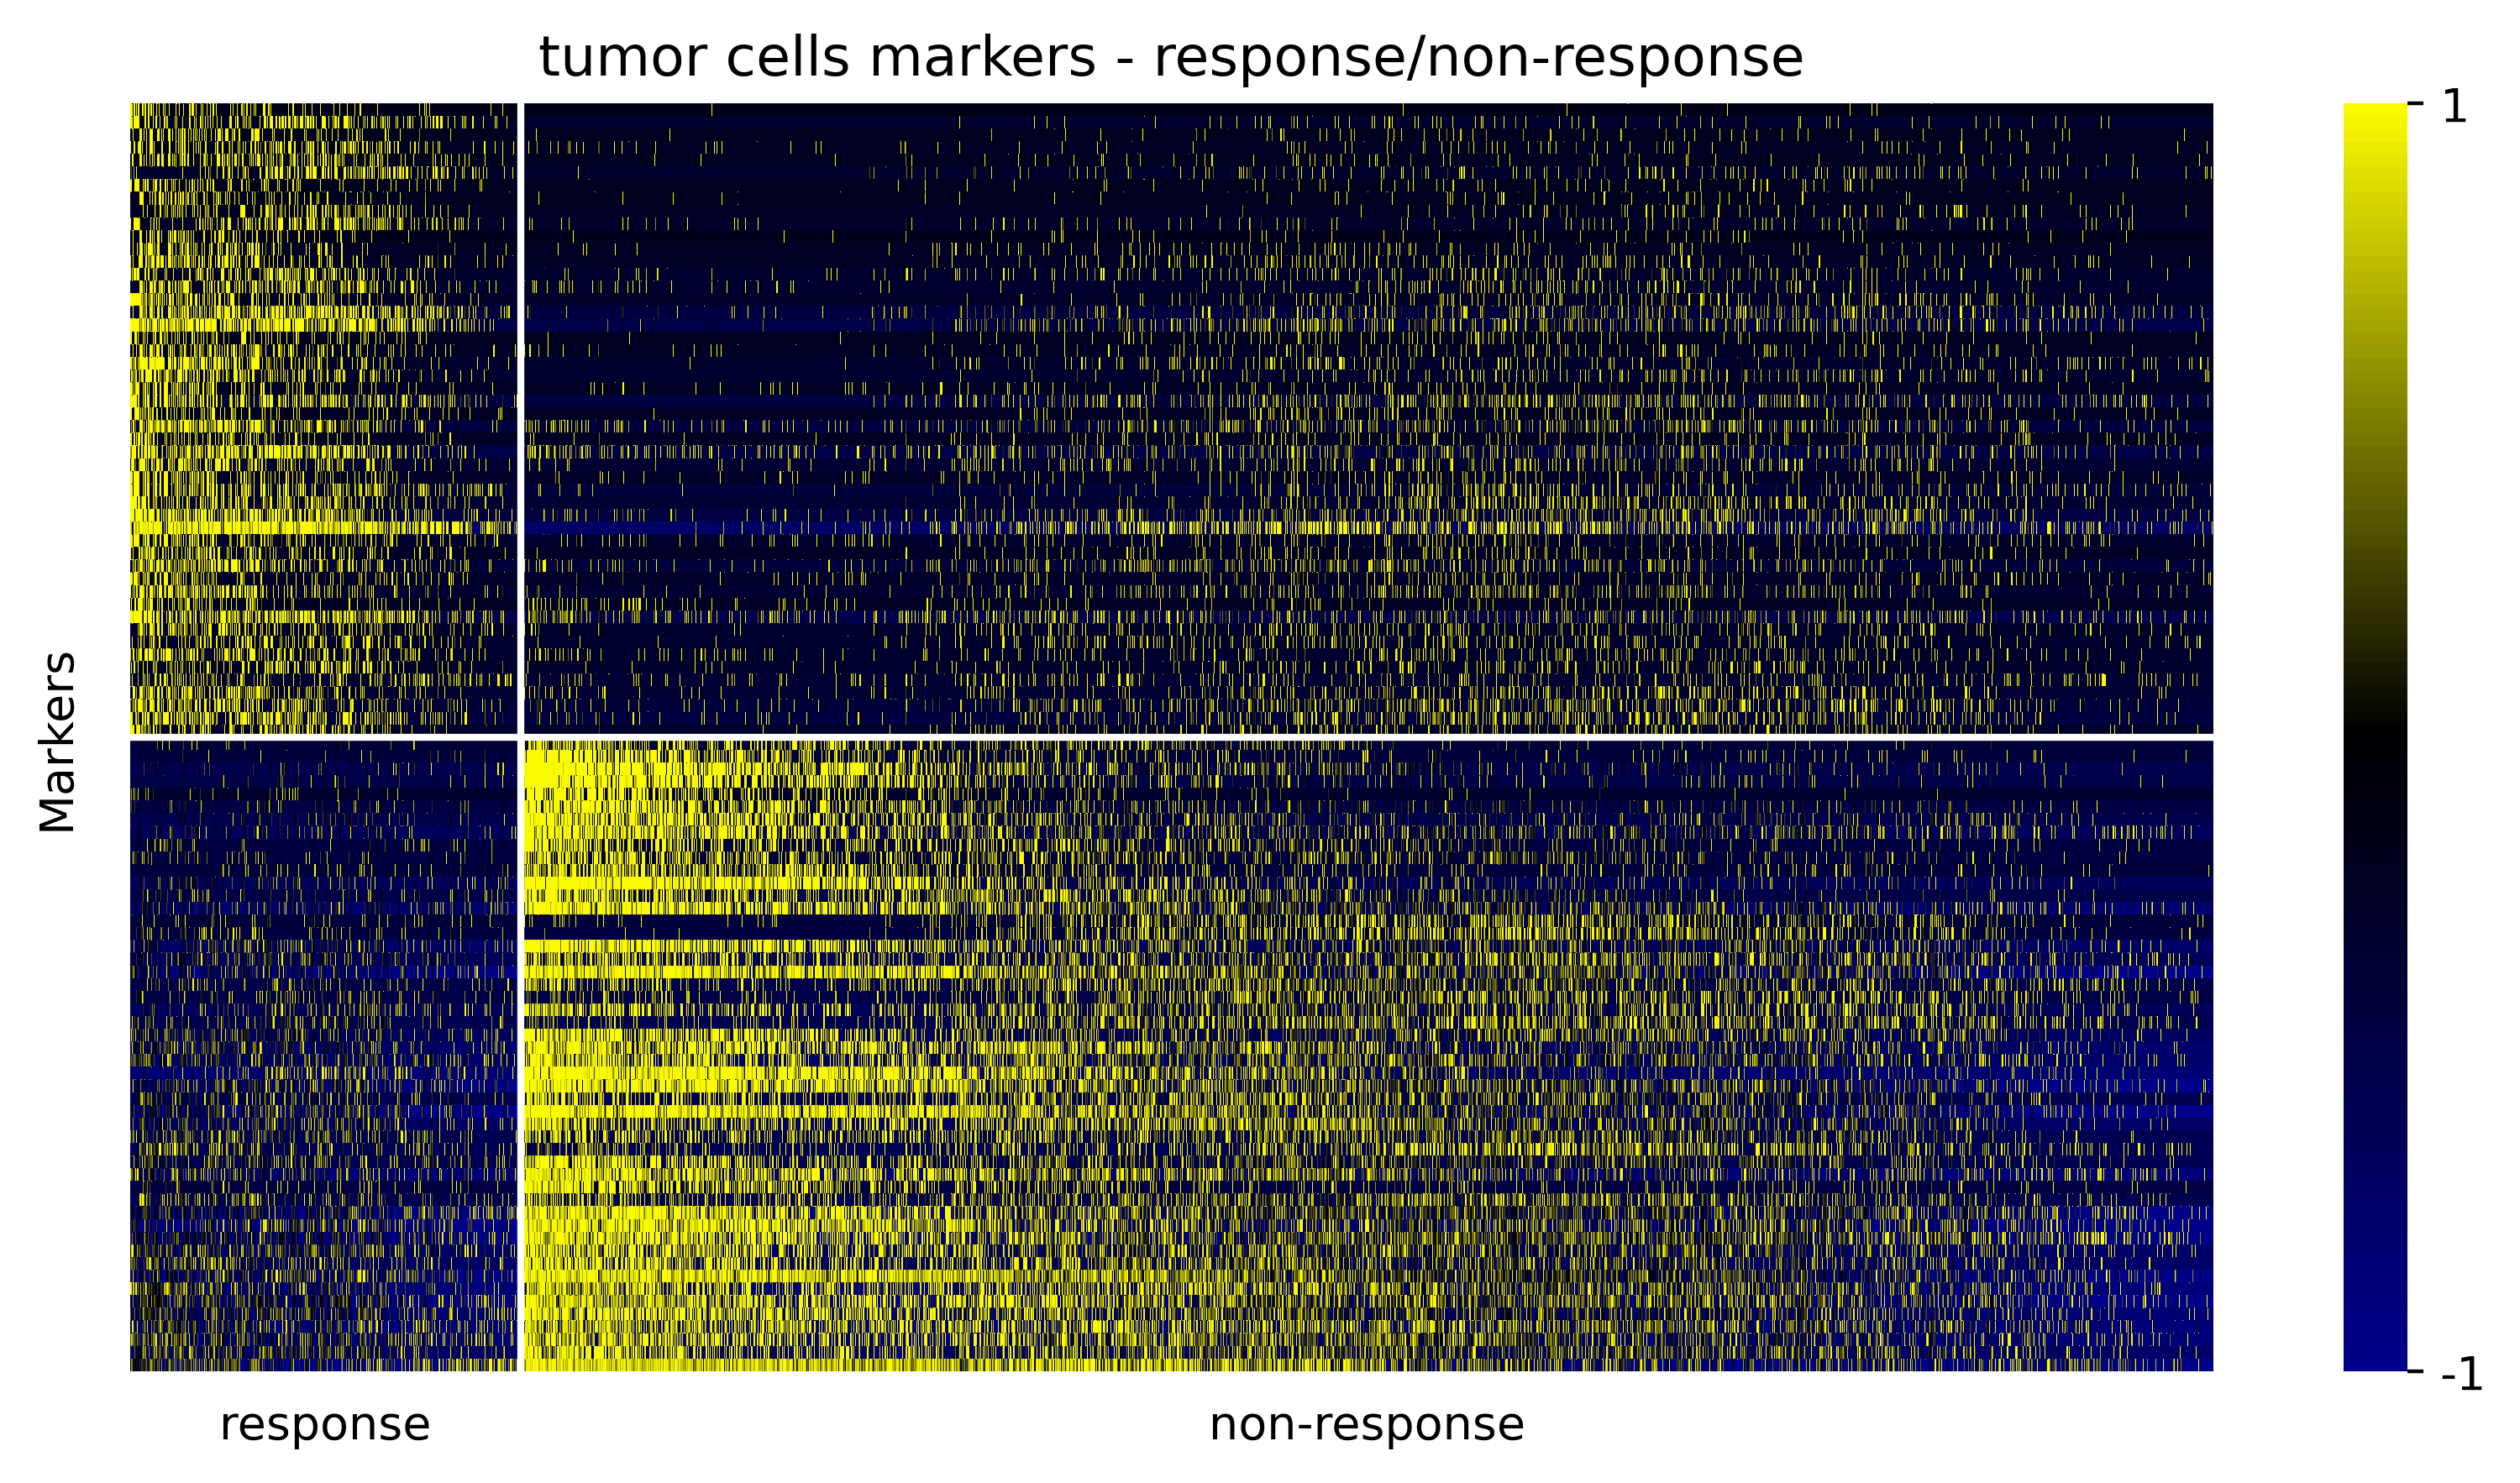

In [16]:
cmap = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/heatmap/colorbar.pkl', 'rb'))
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 5)

sb_out = sb.heatmap(arr_heatmap.T, vmin=-1, vmax=1, cmap=cmap);
cbar = sb_out.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels([-1, 1])


sb_out.set_xticks([int(response_samples_tumor_cells.number_of_cells/2), response_samples_tumor_cells.number_of_cells+int(non_response_samples_tumor_cells.number_of_cells/2) ]) # <--- set the ticks first
sb_out.set_xticklabels(['response', 'non-response'], rotation='horizontal')


# sb_out.set(xticklabels=[])
sb_out.set(yticklabels=[])
sb_out.tick_params(bottom=False, left=False)

ax.axhline(number_of_markers, color='white')
ax.axvline(response_samples_tumor_cells.number_of_cells, color='white')
ax.set_title(f"tumor cells markers - response/non-response");
# ax.set_xlabel('response            non-response');
ax.set_ylabel('Markers');

In [17]:
FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis'
FILE_NAME = r'tumor_cells_marker_heatmap.png'

fig.savefig(join(FOLDER_PATH, FILE_NAME))
response_markers.to_excel(join(FOLDER_PATH, r'response_tumor_markers.xlsx'))
non_response_markers.to_excel(join(FOLDER_PATH, r'non_response_tumor_markers.xlsx'))

## Immune - Differential analysis

In [18]:
response_samples_indices = [s in response_samples for s in immune_cohort.samples]
non_response_samples_indices =[s in non_response_samples for s in immune_cohort.samples]
no_used_samples_indices = [s in no_used_samples for s in immune_cohort.samples]

print(f'number of cells in response_samples_indices: {sum(response_samples_indices)}')
print(f'number of cells in non_response_samples_indices: {sum(non_response_samples_indices)}')
print(f'number of cells in no_used_samples_indices: {sum(no_used_samples_indices)}')

response_samples_immune_cells = immune_cohort[response_samples_indices]
non_response_samples_immune_cells = immune_cohort[non_response_samples_indices]

number of cells in response_samples_indices: 29130
number of cells in non_response_samples_indices: 39016
number of cells in no_used_samples_indices: 11354


##### Conduct fisher's exact test to find markers of response in immune cells:

In [19]:
# from utilities.clustering_tools import find_marker_genes_in_cluster
immune_response_markers = find_marker_genes_in_cluster(response_samples_immune_cells, non_response_samples_immune_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.05)

##### Conduct fisher's exact test to find markers of response in immune cells:

In [20]:
immune_non_response_markers = find_marker_genes_in_cluster(non_response_samples_immune_cells, response_samples_immune_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.05)

##### Builds heatmap:

In [21]:
number_of_markers = 50

In [22]:
# arrange cells indices by mean expression
response_markers_indices = np.array([immune_cohort.features.index(f) for f in immune_response_markers.iloc[:number_of_markers]['features']])
response_cells_indices = np.flip(np.argsort(response_samples_immune_cells.counts[:, response_markers_indices].mean(axis=1)))

non_response_markers_indices = [immune_cohort.features.index(f) for f in immune_non_response_markers.iloc[:number_of_markers]['features']]
non_response_cells_indices = np.flip(np.argsort(non_response_samples_immune_cells.counts[:, non_response_markers_indices].mean(axis=1)))

In [23]:
genes_indices = [immune_cohort.features.index(f) for f in immune_response_markers.iloc[:number_of_markers]['features']] + [immune_cohort.features.index(f) for f in immune_non_response_markers.iloc[:number_of_markers]['features']]
arr_heatmap = np.concatenate([response_samples_immune_cells.counts[response_cells_indices][:, genes_indices], non_response_samples_immune_cells.counts[non_response_cells_indices][:, genes_indices]])
heatmap = np.zeros_like(arr_heatmap)
heatmap[arr_heatmap > 1] = 1
arr_heatmap = scipy.stats.zscore(arr_heatmap, axis=0, ddof=1)

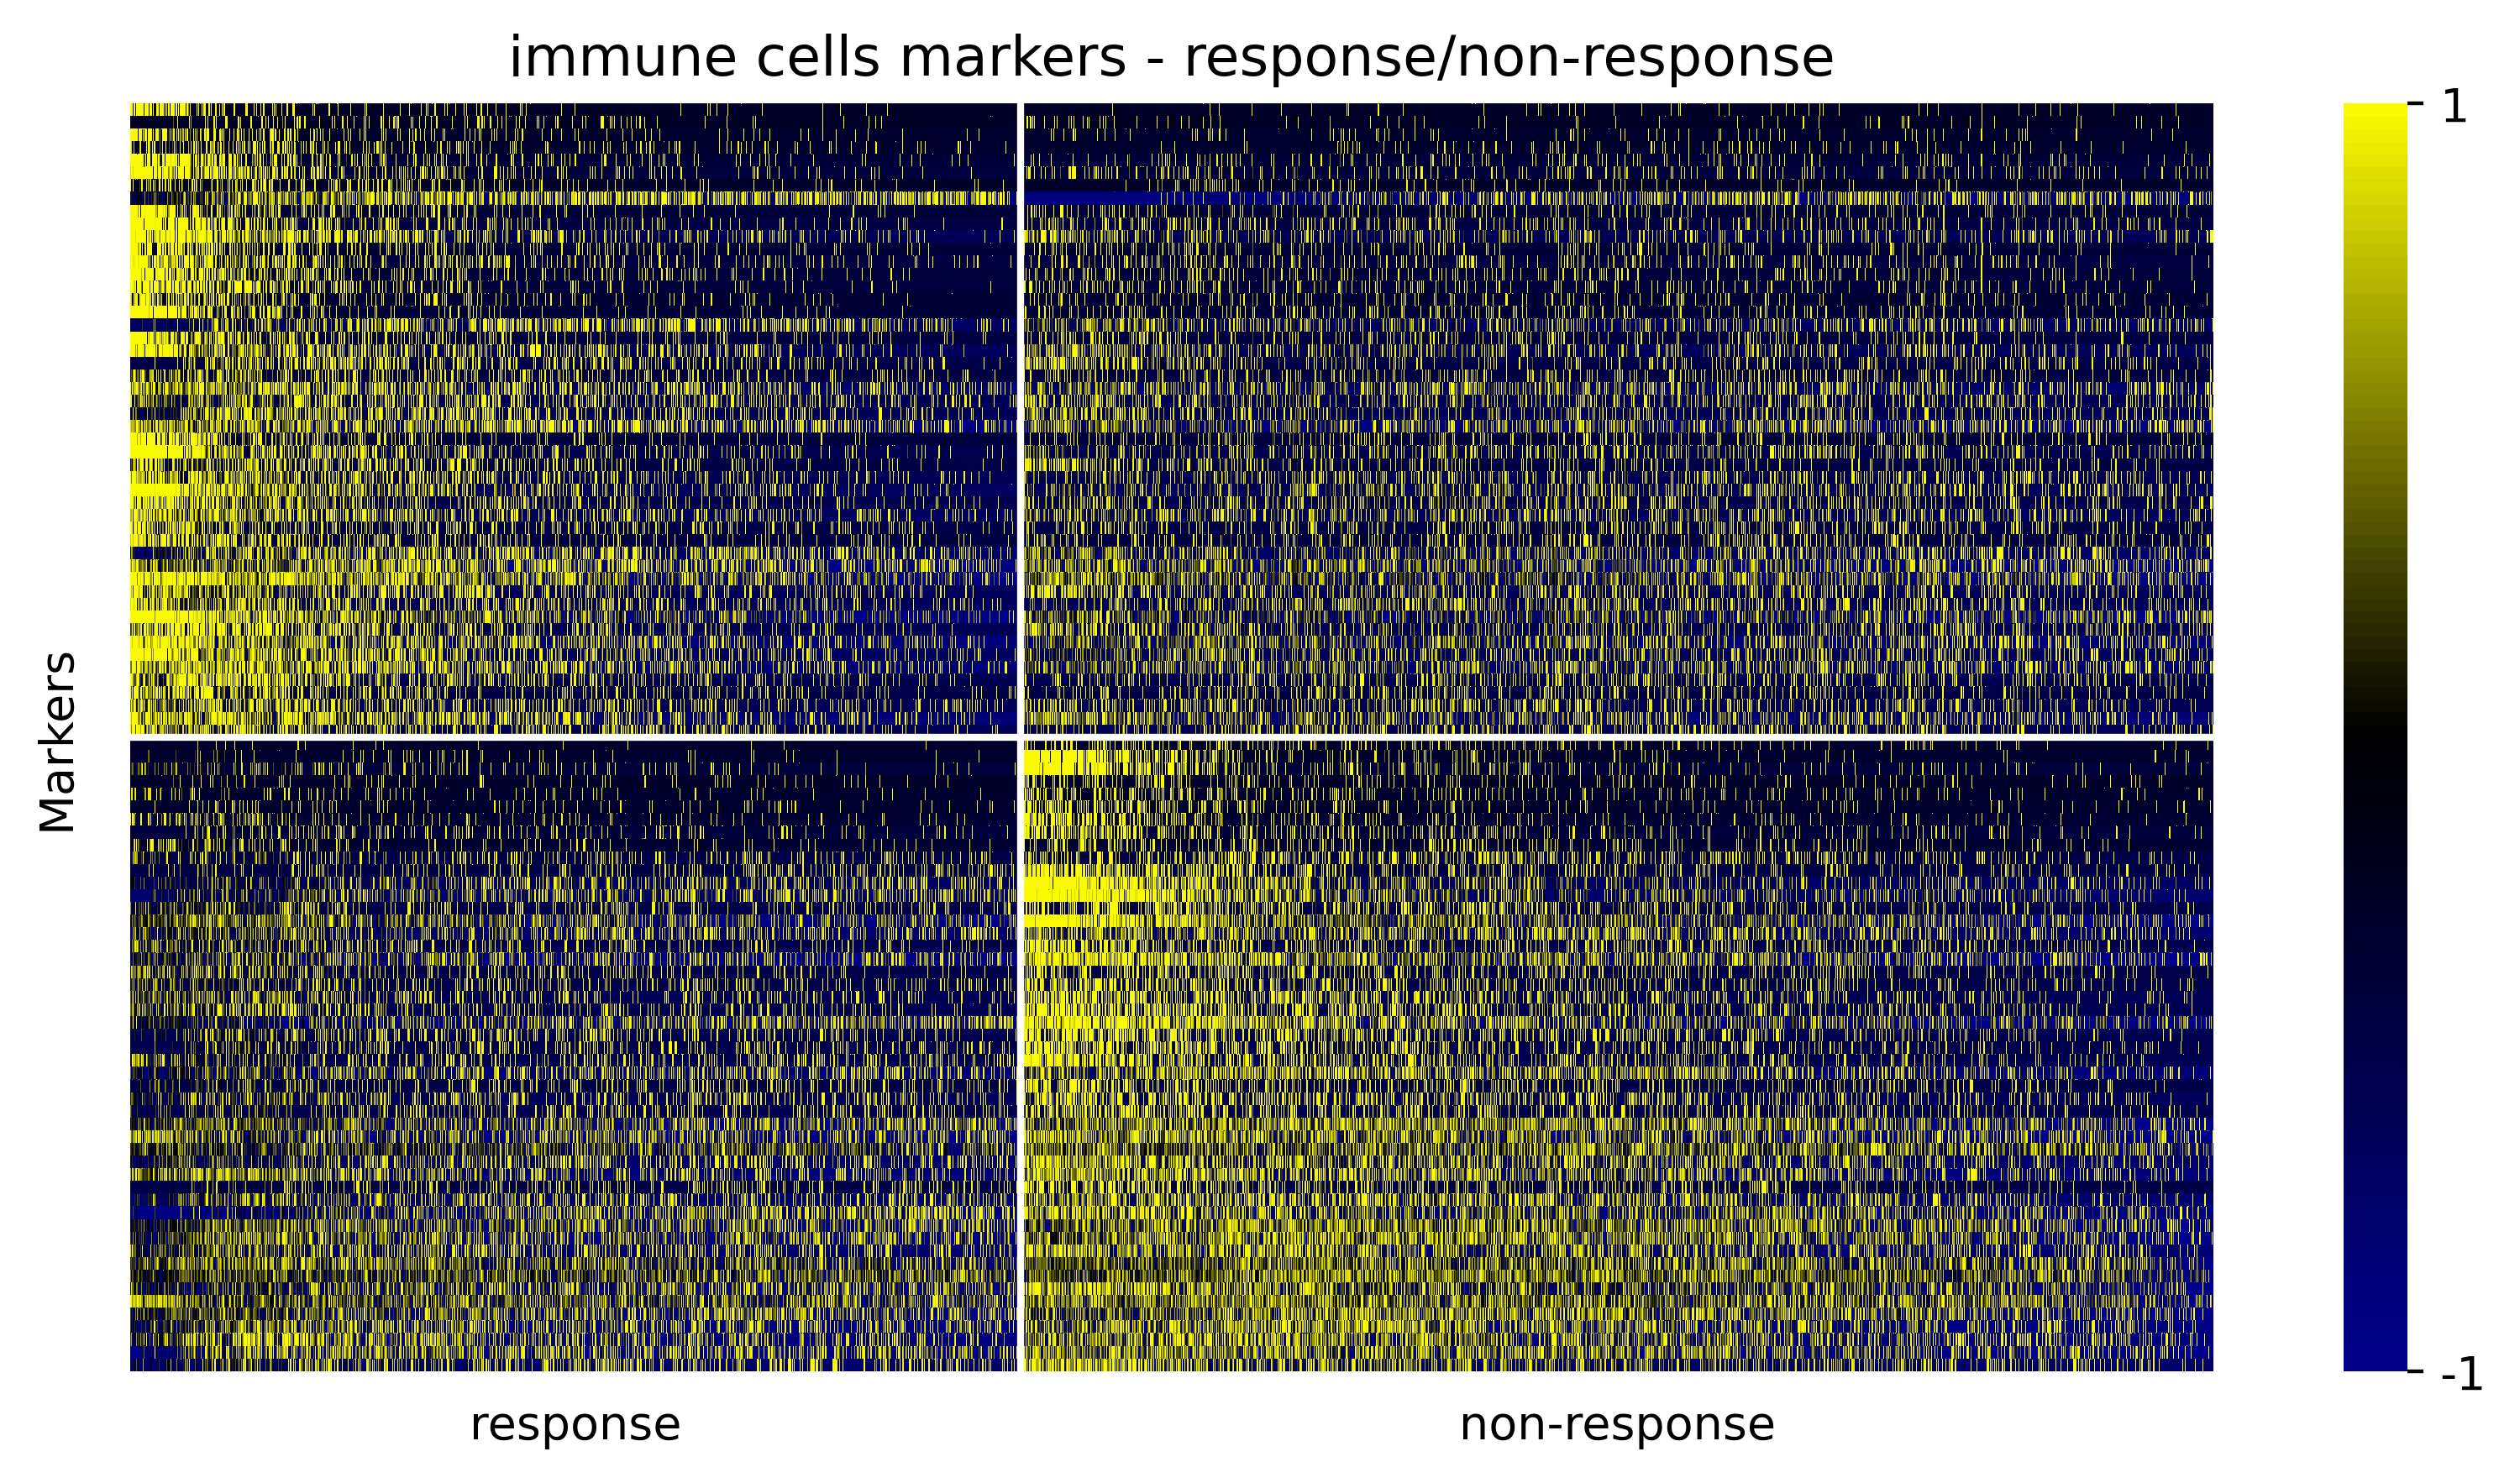

In [24]:
cmap = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/heatmap/colorbar.pkl', 'rb'))
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 5)

sb_out = sb.heatmap(arr_heatmap.T, vmin=-1, vmax=1, cmap=cmap);
cbar = sb_out.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels([-1, 1])


sb_out.set_xticks([int(response_samples_immune_cells.number_of_cells/2), response_samples_immune_cells.number_of_cells+int(non_response_samples_immune_cells.number_of_cells/2) ]) # <--- set the ticks first
sb_out.set_xticklabels(['response', 'non-response'], rotation='horizontal')


# sb_out.set(xticklabels=[])
sb_out.set(yticklabels=[])
sb_out.tick_params(bottom=False, left=False)

ax.axhline(number_of_markers, color='white')
ax.axvline(response_samples_immune_cells.number_of_cells, color='white')
ax.set_title(f"immune cells markers - response/non-response");
# ax.set_xlabel('response            non-response');
ax.set_ylabel('Markers');

In [25]:
FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis'
FILE_NAME = r'immune_cells_marker_heatmap.png'

fig.savefig(join(FOLDER_PATH, FILE_NAME))
immune_response_markers.to_excel(join(FOLDER_PATH, r'response_immune_markers.xlsx'))
immune_non_response_markers.to_excel(join(FOLDER_PATH, r'non_response_immune_markers.xlsx'))

# 2. Response association with clusters analysis

Each cluster see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.


In [29]:
# tumor_cohort.samples
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/garbage/immune_kmeans_26.6.21_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

In [72]:
df = clusters_barcodes_mapping_df.drop(columns=['index'])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')
df['Response'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

n_NR = df['Response'].value_counts()['NR']
n_R = df['Response'].value_counts()['R']

In [84]:
clusters = df['Cluster'].unique()

NR_counts = np.zeros(len(clusters))
R_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    responses = df[df['Cluster']==cluster]['Response']
    NR_counts[idx] = sum(responses=='NR')
    R_counts[idx] = sum(responses=='R')

In [130]:
for idx, (cx, cy) in enumerate(list(zip(NR_counts, R_counts))):
    print(f'cluster {idx+1} -  NR: {int(cx)}, R: {int(cy)}')

print()
print(ranksums(R_counts, NR_counts))
print(wilcoxon(R_counts, NR_counts))

cluster 1 -  NR: 7674, R: 4145
cluster 2 -  NR: 4317, R: 57
cluster 3 -  NR: 963, R: 1649
cluster 4 -  NR: 1717, R: 965
cluster 5 -  NR: 6408, R: 4425
cluster 6 -  NR: 4142, R: 3764
cluster 7 -  NR: 2228, R: 2291
cluster 8 -  NR: 6628, R: 3457
cluster 9 -  NR: 1955, R: 3954
cluster 10 -  NR: 1072, R: 1722
cluster 11 -  NR: 1909, R: 2699

RanksumsResult(statistic=-0.6238176023535313, pvalue=0.5327473782446904)
WilcoxonResult(statistic=22.0, pvalue=0.365234375)


##### Normalizes by group size (number of barcodes in group - R/NR):

In [131]:
R_nor = R_counts/n_R
NR_nor = NR_counts/n_NR

print('Normalized by number of barcodes in group (R/NR):')
for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
    print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')

print()
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

Normalized by number of barcodes in group (R/NR):
cluster 1 -  NR: 0.197, R: 0.142
cluster 2 -  NR: 0.111, R: 0.002
cluster 3 -  NR: 0.025, R: 0.057
cluster 4 -  NR: 0.044, R: 0.033
cluster 5 -  NR: 0.164, R: 0.152
cluster 6 -  NR: 0.106, R: 0.129
cluster 7 -  NR: 0.057, R: 0.079
cluster 8 -  NR: 0.17, R: 0.119
cluster 9 -  NR: 0.05, R: 0.136
cluster 10 -  NR: 0.027, R: 0.059
cluster 11 -  NR: 0.049, R: 0.093

RanksumsResult(statistic=0.2954925484832517, pvalue=0.7676176438012221)
WilcoxonResult(statistic=31.0, pvalue=0.8984375)


##### Normalizes by number of cells in cluster:

In [132]:
NR_nor = NR_counts/(NR_counts + R_counts)
R_nor = R_counts/(NR_counts + R_counts)

print('Normalized by number of barcodes in cluster:')
for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
    print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')
print()    
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

Normalized by number of barcodes in cluster:
cluster 1 -  NR: 0.649, R: 0.351
cluster 2 -  NR: 0.987, R: 0.013
cluster 3 -  NR: 0.369, R: 0.631
cluster 4 -  NR: 0.64, R: 0.36
cluster 5 -  NR: 0.592, R: 0.408
cluster 6 -  NR: 0.524, R: 0.476
cluster 7 -  NR: 0.493, R: 0.507
cluster 8 -  NR: 0.657, R: 0.343
cluster 9 -  NR: 0.331, R: 0.669
cluster 10 -  NR: 0.384, R: 0.616
cluster 11 -  NR: 0.414, R: 0.586

RanksumsResult(statistic=-1.0178076669978668, pvalue=0.30876936771440044)
WilcoxonResult(statistic=25.0, pvalue=0.51953125)


# 3. GEP association with response (1)

Per program, take all usage values of cells coming from R patients vs. NR patients, and perform Wilcoxon ranksum test.


In [39]:
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')

In [40]:
EXEC_DIR = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\outputs\cNMF\executions\tumor_runs\cohort_26.6.21'
selected_K = 32
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
RUN_RANGE = '32'
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
normalized_usage_matrix.head()

1         2         3         4         5   \
M100_AAACCTGAGAAACCAT-1  0.000000  0.109757  0.000010  0.000000  0.000000   
M100_AAACCTGAGACGCAAC-1  0.058619  0.091780  0.000000  0.000000  0.000000   
M100_AAACCTGAGGATTCGG-1  0.000000  0.424668  0.000000  0.025203  0.000000   
M100_AAACCTGAGGGCATGT-1  0.000000  0.042665  0.000000  0.014478  0.000000   
M100_AAACCTGCACGAGAGT-1  0.000000  0.183649  0.038684  0.003126  0.004111   

                               6         7         8    9    10  ...  \
M100_AAACCTGAGAAACCAT-1  0.000000  0.000000  0.007602  0.0  0.0  ...   
M100_AAACCTGAGACGCAAC-1  0.000000  0.000000  0.011205  0.0  0.0  ...   
M100_AAACCTGAGGATTCGG-1  0.004381  0.017075  0.014842  0.0  0.0  ...   
M100_AAACCTGAGGGCATGT-1  0.000000  0.000000  0.002131  0.0  0.0  ...   
M100_AAACCTGCACGAGAGT-1  0.016824  0.000000  0.000000  0.0  0.0  ...   

                               23        24   25   26   27   28        29  \
M100_AAACCTGAGAAACCAT-1  0.110599  0.144449  0.0  0.0  0.0  0.0  0.264192   
M100_AAACCTGAGACGCAAC-1  0.064280  0.068640  0.0  0.0  0.0  0.0  0.311545   
M100_AAACCTGAGGATTCGG-1  0.193017  0.035631  0.0  0.0  0.0  0.0  0.149809   
M100_AAACCTGAGGGCATGT-1  0.010769  0.112147  0.0  0.0  0.0  0.0  0.267276   
M100_AAACCTGCACGAGAGT-1  0.171773  0.160842  0.0  0.0  0.0  0.0  0.095630   

                              30        31        32  
M100_AAACCTGAGAAACCAT-1  0.00000  0.032629  0.144050  
M100_AAACCTGAGACGCAAC-1  0.00000  0.215402  0.096382  
M100_AAACCTGAGGATTCGG-1  0.00000  0.000000  0.086767  
M100_AAACCTGAGGGCATGT-1  0.00000  0.239131  0.113527  
M100_AAACCTGCACGAGAGT-1  0.01206  0.000000  0.030204  

[5 rows x 32 columns]

In [41]:
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
df['Response'] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

df_r = df[df['Response']=='R']
df_nr = df[df['Response']=='NR']

In [42]:
pvals = np.zeros(selected_K)
for i in range(1, selected_K+1):
    pvals[i-1] = ranksums(df_r[i].values, df_nr[i].values)[1]
    
pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, selected_K+1)])], columns=['pval', 'program'])

In [43]:
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_rows', 10)

pvals_df['<0.05'] = pvals_df['pval'] < 0.05
pvals_df

pval  program  <0.05
0    0.000000e+00        1   True
1   4.547523e-226        2   True
2   6.768536e-108        3   True
3    1.004579e-02        4   True
4    3.182273e-47        5   True
5    1.158261e-02        6   True
6    4.255408e-01        7  False
7    7.748333e-01        8  False
8    4.022741e-42        9   True
9    2.258272e-01       10  False
10  4.019866e-125       11   True
11   5.780629e-10       12   True
12   1.772246e-01       13  False
13   0.000000e+00       14   True
14   4.775346e-41       15   True
15   5.038881e-49       16   True
16  5.513188e-124       17   True
17   1.509498e-73       18   True
18   0.000000e+00       19   True
19   5.287769e-05       20   True
20   0.000000e+00       21   True
21   1.206158e-19       22   True
22  4.299366e-147       23   True
23   0.000000e+00       24   True
24   1.579463e-04       25   True
25   7.287518e-62       26   True
26   4.511156e-07       27   True
27   2.098424e-23       28   True
28  7.726928e-113       29   True
29   1.230238e-06       30   True
30  3.296867e-180       31   True
31   7.011139e-02       32  False

In [44]:
# sns.reset_orig()
import itertools
index = [(x,y) for x in np.arange(11) for y in np.arange(3)]

fig, axs = plt.subplots(11, 3)
fig.set_size_inches(32, 62)
# g = sns.boxplot(, x="Year", y="Expenses", data=table)
# sns.boxplot(ax=ax[0,0], y=1, x='Response', data=df, kind="box",height=5, aspect=1.2).set(title=f'Program 1');
for i in range(32):
    axs[index[i][0], index[i][1]].set_title(f"Program {i+1}")
    sns.boxplot(ax=axs[index[i][0], index[i][1]], y=i+1, x='Response', data=df).set(title=f'Program {i+1}');

# 4. GEP association with response (2)

Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between R and NR patients.


In [ ]:
df

# Debug

In [9]:
from scipy.stats import rankdata
import scipy.stats as stats
def multipletests_fdr(p_vals, alpha=0.05):
    """
    Test results and p-value correction for multiple tests using Benjamini/Hochberg method.
    :param p_vals: np.array of pvals
    :return: pvals_corrected
    """

    ranked_p_values = rankdata(p_vals)
    pvals_corrected = p_vals * len(p_vals) / ranked_p_values
    pvals_corrected[pvals_corrected > 1] = 1

    return pvals_corrected < alpha, pvals_corrected


def find_marker_genes_in_cluster(cluster_data, other_clusters_data, log_FC_threshold, pval_threshold,
                                 min_pct, min_diff_pct):
    """
    After the clustering process has been done run this function to find marker genes for each cluster.
    The function conducts a Fisher Exact Test for every gene to check whether that gene constitutes a marker
    of one of the clusters. Obviously, we conduct a test per cluster. that means that if we have k clusters and n
    genes we will have k*n tests.
    We test whether the gene in the cluster expresses differently of the other clusters.
    we define expressed as value > 1 (after normalization). and we test the proportion between the number of cells
    expressing each gene compered to all other clusters together.
    because we conduct many statistical test we will correct the pvalues using Benjamini/Hochberg correction
    :param Data_RNAseq: Can be cohort object or singular RNAseq object which all its cells having association to one of the clusters.
    :param clusters_list: cluster in size of number of cells such that each place indicate which cluster corresponds
    to that cell (number of cluster).
    :param min_diff_pct:
    minimum percent difference between the percent of cells expressing the gene in the cluster
    and the percent of cells expressing gene in all other clusters combined.

    :param min_pct: 0.1
    only test genes that are detected in a minimum fraction of cells in either of the two populations.

    Note: Marker defined as gene with pval < pval_thresh and log_FC < log_ratio_threshold
    :return:
    gene names - of all gene markers, ordered by pval_corrected
    gene ids - of all gene markers, ordered by pval_corrected
    pval - of all gene markers, ordered by pval_corrected
    log ratios - of all gene markers, ordered by pval_corrected
    """

    n_cells_in_cluster = len(cluster_data.counts)
    n_cells_in_other_clusters = len(other_clusters_data.counts)
    min_expression_threshold = 1    # for a cell to be counted as a cell that expresses the gene

    df = pd.DataFrame()
    df['features'] = cluster_data.features
    df['gene names'] = cluster_data.gene_names
    df['(1)mean_expression'] = np.mean(cluster_data.counts, axis=0)
    df['(2)mean expression'] = np.mean(other_clusters_data.counts, axis=0)
    df['log_FC'] = np.log2((df['(1)mean_expression'] + 0.01) / (df['(2)mean expression'] + 0.01))
    df['(1)#expressing'] = np.sum((cluster_data.counts > min_expression_threshold), axis=0)
    df['(2)#expressing'] = np.sum((other_clusters_data.counts > min_expression_threshold), axis=0)
    df['(1)%expressing'] = df['(1)#expressing'] / n_cells_in_cluster
    df['(2)%expressing'] = df['(2)#expressing'] / n_cells_in_other_clusters
    df['%expressing_diff'] = df['(1)%expressing'] - df['(2)%expressing']

    # filters not satisfying genes.
    df = df[(df["(1)%expressing"] > min_pct)]
    df = df[(df["%expressing_diff"] > min_diff_pct)]
    df = df[(df['log_FC'] > log_FC_threshold)]
    df = df.sort_values(['log_FC'], ascending=False)

    p_values = []  # before correction
    for index, row in df.iterrows():
        number_of_cells_expressing_gene_in_cluster = row["(1)#expressing"]
        number_of_cells_expressing_gene_in_other_clusters = row["(2)#expressing"]

        oddsratio, pvalue = stats.fisher_exact([[number_of_cells_expressing_gene_in_cluster,
                                                 number_of_cells_expressing_gene_in_other_clusters],
                                                [n_cells_in_cluster - number_of_cells_expressing_gene_in_cluster,
                                                 n_cells_in_other_clusters - number_of_cells_expressing_gene_in_other_clusters]])

        p_values.append(pvalue)

    reject_arr, pvals_corrected = multipletests_fdr(np.array(p_values), alpha=0.05)

    df['pvals'] = pvals_corrected.tolist()
    df = df[df['pvals'] < pval_threshold]

    return df

In [142]:
# find_marker_genes_in_cluster(non_response_samples_immune_cells, response_samples_immune_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)
cluster_data = non_response_samples_immune_cells
other_clusters_data =  response_samples_immune_cells
log_FC_threshold=0.05
pval_threshold=0.05
min_pct=0.1
min_diff_pct=0.1

n_cells_in_cluster = len(cluster_data.counts)
n_cells_in_other_clusters = len(other_clusters_data.counts)
min_expression_threshold = 1    # for a cell to be counted as a cell that expresses the gene

df = pd.DataFrame()
df['features'] = cluster_data.features
df['gene names'] = cluster_data.gene_names
df['(1)mean_expression'] = np.mean(cluster_data.counts, axis=0)
df['(2)mean expression'] = np.mean(other_clusters_data.counts, axis=0)
df['log_FC'] = np.log2((df['(1)mean_expression'] + 0.01) / (df['(2)mean expression'] + 0.01))
df['(1)#expressing'] = np.sum((cluster_data.counts > min_expression_threshold), axis=0)
df['(2)#expressing'] = np.sum((other_clusters_data.counts > min_expression_threshold), axis=0)
df['(1)%expressing'] = df['(1)#expressing'] / n_cells_in_cluster
df['(2)%expressing'] = df['(2)#expressing'] / n_cells_in_other_clusters
df['%expressing_diff'] = df['(1)%expressing'] - df['(2)%expressing']

In [139]:
df = df[(df["(1)%expressing"] > min_pct)]

In [158]:
df.sort_values(['%expressing_diff'], ascending=False)
df[(df["%expressing_diff"] > 0.05)]

features    gene names  (1)mean_expression  (2)mean expression  \
74     ENSG00000005022       SLC25A5            1.361568            1.230204   
334    ENSG00000013441          CLK1            0.548923            0.461063   
357    ENSG00000015285           WAS            0.738072            0.596710   
1511   ENSG00000080824      HSP90AA1            1.969967            1.521347   
1836   ENSG00000089327         FXYD5            2.357033            2.204333   
2052   ENSG00000096060         FKBP5            0.751687            0.624819   
2060   ENSG00000096384      HSP90AB1            1.636472            1.271685   
2123   ENSG00000099860       GADD45B            0.707798            0.560311   
2185   ENSG00000100100       PIK3IP1            0.568488            0.491259   
2195   ENSG00000100129         EIF3L            1.079233            0.938644   
2909   ENSG00000104408         EIF3E            1.217823            1.024341   
3039   ENSG00000105193         RPS16            3.543489            3.148770   
3931   ENSG00000111716          LDHB            1.587928            1.438874   
4466   ENSG00000115738           ID2            0.714061            0.553113   
4601   ENSG00000116741          RGS2            0.529194            0.348541   
4733   ENSG00000117616       C1orf63            1.007257            0.918380   
5068   ENSG00000120694         HSPH1            0.323323            0.190800   
5205   ENSG00000121966         CXCR4            1.705601            1.486092   
5357   ENSG00000123358         NR4A1            0.347096            0.198091   
5613   ENSG00000125354         SEPT6            0.801154            0.680659   
5678   ENSG00000125740          FOSB            0.681139            0.486043   
5953   ENSG00000128016         ZFP36            2.327522            2.069515   
6304   ENSG00000130741        EIF2S3            0.568657            0.430168   
6363   ENSG00000131051         RBM39            1.080230            0.950391   
6498   ENSG00000132002        DNAJB1            1.343484            0.966523   
7294   ENSG00000136717          BIN1            0.665979            0.549164   
8020   ENSG00000140988          RPS2            2.452094            2.254894   
8220   ENSG00000142541        RPL13A            1.803940            1.617806   
8528   ENSG00000144381         HSPD1            0.674824            0.549217   
8967   ENSG00000147604          RPL7            2.060481            1.799722   
8979   ENSG00000147677         EIF3H            1.367943            1.232314   
9280   ENSG00000150593         PDCD4            0.633736            0.539220   
10013  ENSG00000156976        EIF4A2            1.069924            0.922738   
10621  ENSG00000161960        EIF4A1            1.296818            1.120175   
10710  ENSG00000162511        LAPTM5            2.546922            2.270182   
10818  ENSG00000162894         FAIM3            0.658715            0.543894   
11809  ENSG00000166441        RPL27A            2.049144            1.754628   
12245  ENSG00000168209         DDIT4            1.509301            1.376970   
12456  ENSG00000169100       SLC25A6            1.903121            1.668373   
12726  ENSG00000170345           FOS            2.368267            1.943427   
13475  ENSG00000173674        EIF1AX            0.539497            0.426304   
14180  ENSG00000177606           JUN            1.639759            1.209876   
14544  ENSG00000179820         MYADM            0.302900            0.200086   
15724  ENSG00000185650       ZFP36L1            1.715020            1.475612   
15792  ENSG00000185905      C16orf54            0.222881            0.121408   
16634  ENSG00000196262          PPIA            3.044100            2.815988   
17379  ENSG00000198695        MT-ND6            1.235401            0.953854   
17420  ENSG00000198786        MT-ND5            3.145291            2.710672   
17804  ENSG00000204388        HSPA1B            0.567313            0.124682   
17805  ENSG000

In [141]:
df = df[(df["%expressing_diff"] > min_diff_pct)]
df

features gene names  (1)mean_expression  (2)mean expression  \
17804  ENSG00000204388     HSPA1B            0.567313            0.124682   
20988  ENSG00000229807       XIST            0.278590            0.054064   

         log_FC  (1)#expressing  (2)#expressing  (1)%expressing  \
17804  2.099801            6678            1322        0.171161   
20988  2.171435            5004             635        0.128255   

       (2)%expressing  %expressing_diff  
17804        0.045383          0.125778  
20988        0.021799          0.106456

In [ ]:


df = df[(df['log_FC'] > log_FC_threshold)]
df = df.sort_values(['log_FC'], ascending=False)

p_values = []  # before correction
for index, row in df.iterrows():
    number_of_cells_expressing_gene_in_cluster = row["(1)#expressing"]
    number_of_cells_expressing_gene_in_other_clusters = row["(2)#expressing"]

    oddsratio, pvalue = stats.fisher_exact([[number_of_cells_expressing_gene_in_cluster,
                                             number_of_cells_expressing_gene_in_other_clusters],
                                            [n_cells_in_cluster - number_of_cells_expressing_gene_in_cluster,
                                             n_cells_in_other_clusters - number_of_cells_expressing_gene_in_other_clusters]])

    p_values.append(pvalue)

reject_arr, pvals_corrected = multipletests_fdr(np.array(p_values), alpha=0.05)

df['pvals'] = pvals_corrected.tolist()
df = df[df['pvals'] < pval_threshold]

return df